# HPC Assignment 1 - VCYQ6

 <b>Candidate Number: VCYQ6

Student Number: 18018226 <b>

In [1]:
#import all libraries
import numpy as np
import timeit
import matplotlib.pyplot as plt
from numba import njit, jit, prange, cuda, float32

## Point 1

*Benchmark the above function against the Numpy dot product for matrix sizes up to 1000. Plot the timing results of the above function against the timing results for the Numpy dot product. You need not benchmark every dimension up to 1000. Figure out what dimensions to use so that you can represent the result without spending too much time waiting for the code to finish. To perform benchmarks you can use the %timeit magic command.*

- First we define numpy and our matrix multiplication function.  

In [2]:
#Original matrix multiplication function
def matrix_product(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in range(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

In [3]:
#Numpy matrix multiplication function
def numpy_matrix_product(mat_a, mat_b):
    """Returns the product of the matrices mat_a and mat_b."""
    
    mat_c = mat_a @ mat_b
    
    return mat_c

We calculate the error of both functions.

In [4]:
#Define two 10x10 matrices
a = np.random.randn(10, 10)
b = np.random.randn(10, 10)

#Calculate the product with out functions
c_actual = matrix_product(a, b)
c_expected = numpy_matrix_product(a, b)

#Calculate the error
error = np.linalg.norm(c_actual - c_expected) / np.linalg.norm(c_expected)
print(f"The error is {error}.")

The error is 1.2848660426334762e-16.


We obtain neglible error. Now, we will benchmark both functions for matrices up to a 1000 dimensions. We will use the timeit in-built python library to benchmark these functions. The timeit function decides how many times to run the specified expression based on its run time, and provides information the about mean run time and the standard deviation over the ensemble of runs. We will also save the best times of the ensembles of run using the best functionality. 

In [5]:
# Benchmark our functions for matrices of different dimensions

n = (50, 100, 500, 750, 1000)      #dimensions we want to benchamark
numpy_time = np.zeros(len(n))      #array of the best times that numpy function takes
function_time = np.zeros(len(n))   #array of the best times that the original function takes

#Compute matrices for n dimensions
for i in range(len(n)):
    a = np.random.randn(n[i], n[i])
    b = np.random.randn(n[i], n[i])
    
    #get the benchmark for the numpy function
    print(f"For a matrix with size of {a.shape}, the Numpy function takes:")
    timeit_result_numpy = %timeit -o numpy_matrix_product(a, b)
    numpy_time[i] = timeit_result_numpy.best
    
    print()
    
    #get the benchmark for the original function
    print(f"For two matrices of size of {a.shape}, the original function takes:")
    timeit_result_function = %timeit -o matrix_product(a, b)
    function_time[i] = timeit_result_function.best
    
    print()

For a matrix with size of (50, 50), the Numpy function takes:
9.85 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

For two matrices of size of (50, 50), the original function takes:
112 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

For a matrix with size of (100, 100), the Numpy function takes:
32.2 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

For two matrices of size of (100, 100), the original function takes:
796 ms ± 59.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

For a matrix with size of (500, 500), the Numpy function takes:
3.72 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

For two matrices of size of (500, 500), the original function takes:
1min 31s ± 2.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

For a matrix with size of (750, 750), the Numpy function takes:
9.87 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

For two matrices of size of (750, 75

The timeit library will limit the number of runs and loops depending on how long the script takes to execute. It can be observed that the original function takes longer than the Numpy function, and hence as the number of dimensions increase, the number of loops decrease for both functions. Because the Numpy function performs better than the original function, it will be able to iterate more times. 

- We will not plot the best times of our functions against the set of dimensions.

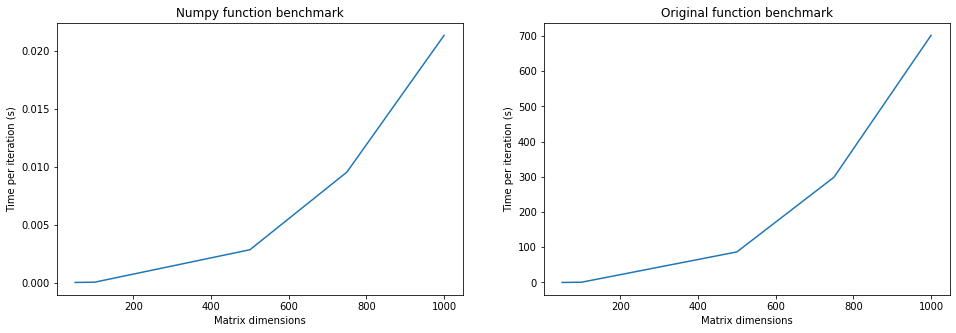

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,5))
ax1.plot(n, numpy_time)     #number of dimensions against numpy best benchmark time
ax2.plot(n, function_time)  #number of dimensions against the original function best benchmark time

#Set the titles
ax1.set_title("Numpy function benchmark")
ax2.set_title('Original function benchmark')

#Set the labels
ax1.set_xlabel("Matrix dimensions")
ax1.set_ylabel("Time per iteration (s)")
ax2.set_xlabel("Matrix dimensions")
ax2.set_ylabel("Time per iteration (s)")

#Plot results
plt.show()

The benchmark time for both functions linearly increases with respect to the number of dimensions, approximately. However, the Numpy function performs better than the orginal one, as it takes less time to compute the matrix multiplication. This can be seen more clearly by plotting the ratio between both functions benchmark time. 

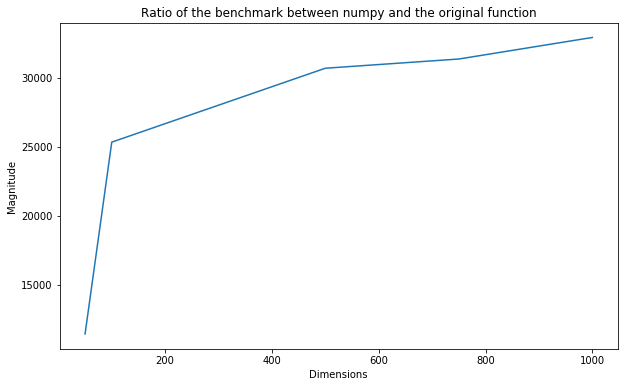

In [7]:
#Calculate the ratio
ratio_numpy_original = function_time / numpy_time

#Plot the ratio against the number of dimensions
plt.figure(figsize =(10,6))
plt.plot(n, ratio_numpy_original)

#Set the legend, labels and title
plt.title("Ratio of the benchmark between numpy and the original function")
plt.xlabel("Dimensions")
plt.ylabel("Magnitude")

#Plot results
plt.show()

From the graph above it can be observed that as the number of dimensions increase, the Numpy function performs better than the original function by a factor of $10^4$. This is a huge difference, particularly when it comes to large dimensions that could take longer to run. One of the reasons for Numpy's speedup is due to its specialized multi-dimensional, homogeneous fixed-size array which contains block of memory, indexing scheme, and data descriptor [3].

In the following sections, we will use Numba to improve the performance of our original function. The goal is to approximate its performance as much as possible to Numpy's performance. 

## Point 2 

*Now optimise the code by using Numba to JIT-compile it. Also, there is lots of scope for parallelisation in the code. You can for example parallelize the outer-most for-loop. Benchmark the JIT-compiled serial code against the JIT-compiled parallel code. Comment on the expected performance on your system against the observed performance.*

- First we compile the python code into fast machine code using Numba and then we will measure its performance. All that we need is the decorator @njit.

In [72]:
@njit()   #apply the njit decorator to compile the code into fast machine code
def jit_serial_matrix_product(mat_a, mat_b):
    "Returns the compiled product of the matrices mat_a and mat_b."
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in range(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

In [73]:
# Benchmark our function for matrices of different dimensions

n = (50, 100, 500, 750, 1000)     #dimensions we want to benchamark
serial_time = np.zeros(len(n))    #array of the best times that the JIT-compiled serial code takes

#Compute matrices for n dimensions
for i in range(len(n)):
    a = np.random.randn(n[i], n[i])
    b = np.random.randn(n[i], n[i])
    
    #get the benchmark for the JIT-compiled serial function
    print(f"For two matrices of size of {a.shape}, the JIT-compiled serial code takes:")
    timeit_result_function_serial = %timeit -o jit_serial_matrix_product(a, b)
    serial_time[i] = timeit_result_function_serial.best
    
    print()

For two matrices of size of (50, 50), the JIT-compiled serial code takes:
108 µs ± 7.97 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

For two matrices of size of (100, 100), the JIT-compiled serial code takes:
999 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For two matrices of size of (500, 500), the JIT-compiled serial code takes:
165 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

For two matrices of size of (750, 750), the JIT-compiled serial code takes:
777 ms ± 3.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

For two matrices of size of (1000, 1000), the JIT-compiled serial code takes:
1.76 s ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



This is still slow compared to Numpy results. One way to keep improving the performance of our code is by parallelising the for loops with the command prange, which tells Numba to spread out the computation to multiple CPU cores. 

- We apply prange to the outer for loop as it preallocates the processes for the following loops and measure its performance. 

In [74]:
@njit(parallel = True)
def jit_parallel_matrix_product(mat_a, mat_b):
    """Returns the compiled and parallelised product of the matrices mat_a and mat_b."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in prange(m):     #apply prange instead of range to the outer loop to parallelise it
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

In [75]:
# Benchmark our function for matrices of different dimensions

n = (50, 100, 500, 750, 1000)     #dimensions we want to benchamark
parallel_time = np.zeros(len(n))  #array of the best times that the JIT-compiled parallel code takes

#Compute matrices for n dimensions
for i in range(len(n)):
    a = np.random.randn(n[i], n[i])
    b = np.random.randn(n[i], n[i])
    
    #get the benchmark for the JIT-compiled parallel function
    print(f"For two matrices of size of {a.shape}, the JIT-compiled parallel code takes:")
    timeit_result_function_parallel = %timeit -o jit_parallel_matrix_product(a, b)
    parallel_time[i] = timeit_result_function_parallel.best
    
    print()

For two matrices of size of (50, 50), the JIT-compiled parallel code takes:
70.5 µs ± 23.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

For two matrices of size of (100, 100), the JIT-compiled parallel code takes:
289 µs ± 2.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For two matrices of size of (500, 500), the JIT-compiled parallel code takes:
62.3 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

For two matrices of size of (750, 750), the JIT-compiled parallel code takes:
307 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

For two matrices of size of (1000, 1000), the JIT-compiled parallel code takes:
1.66 s ± 47.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



- Plot the JIT-compiled parallel and serial function benchmark times against the number of dimensions.

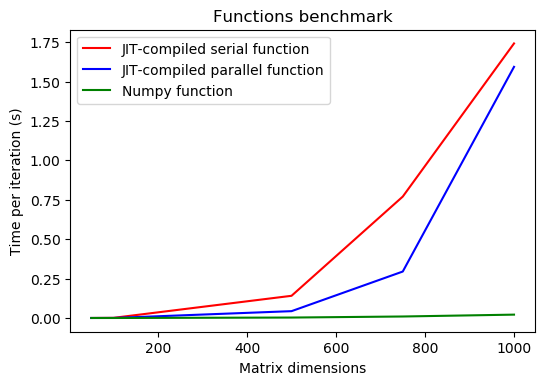

In [76]:
plt.figure(dpi=100)

#Plot the JIT-compiled serial time against the number of dimensions
plt.plot(n, serial_time, 'r', label = "JIT-compiled serial function")

#Plot the JIT-compiled parallel time against the number of dimensions
plt.plot(n, parallel_time, 'b', label = "JIT-compiled parallel function")

#Plot the Numpy time against the number of dimensions
plt.plot(n, numpy_time, 'g', label = "Numpy function")

#Set the legend, labels and title
plt.legend()
plt.xlabel("Matrix dimensions")
plt.ylabel("Time per iteration (s)")
plt.title("Functions benchmark")

#Plot results
plt.show()

From the graph above it can be observed that the JIT-compiled parallel function performs better than the JIT-compiled serial function, but still not better than the Numpy function. We can compute the ratios of the serial and parallel function against the Numpy and original function to check how much our code has improved. 

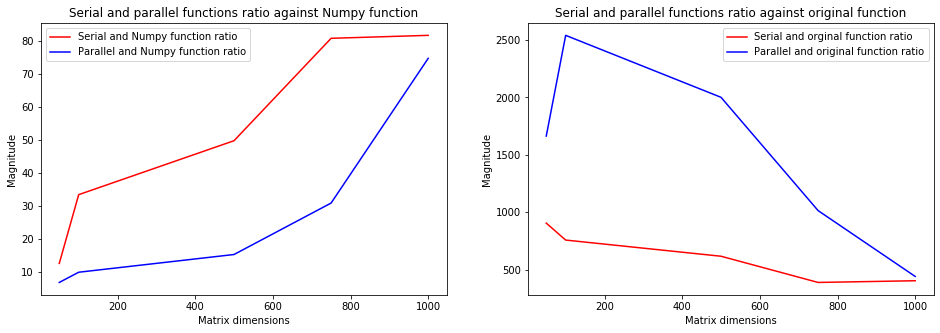

In [77]:
#Compute the ratios
ratio_numpy_serial = serial_time / numpy_time 
ratio_numpy_parallel = parallel_time / numpy_time

ratio_serial_original = function_time / serial_time 
ratio_parallel_original = function_time / parallel_time

#Plot the ratios against the number of dimensions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,5))
ax1.plot(n, ratio_numpy_serial, 'r', label = 'Serial and Numpy function ratio')
ax1.plot(n, ratio_numpy_parallel, 'b', label = 'Parallel and Numpy function ratio')

ax2.plot(n, ratio_serial_original, 'r', label = 'Serial and orginal function ratio')
ax2.plot(n, ratio_parallel_original, 'b', label = 'Parallel and original function ratio')

#Set the labels, legends and title
ax1.set_title('Serial and parallel functions ratio against Numpy function')
ax1.set_xlabel('Matrix dimensions')
ax1.set_ylabel('Magnitude')
ax1.legend()

ax2.set_title('Serial and parallel functions ratio against original function')
ax2.set_xlabel('Matrix dimensions')
ax2.set_ylabel('Magnitude')
ax2.legend()

#Show results
plt.show()

These graphs show that the JIT compilled parallel function performed better than the JIT compilled serial function for higher dimensions. 

On the first graph we are comparing the serial and parallel best times with the numpy best time. It can be observed that the parallel code approximately takes 76 times Numpy's best benchmark time for a matrix of 1000x1000, while the serial code takes 85 times more than Numpy's best benchmark time. However, for a 10x10 matrix the parallel code approximately takes 17 times Numpy's best benchmark time and the serial 13 times Numpy's best benchmark time. So uo to a matrix of size 10x10, the serial code performs better than the parallel code. Up from 10 dimensions, the parallel code perform better. 

On the second graph we are comparing the serial and parallel best times with the original function best time. It can be observed that the original function approximately takes 390 times both the parallel and serial code best benchmark time for 1000x1000 matrices. For a 10x10 matrix the original function takes 658 times the serial best benchmark time and 883 times the parallel best benchmark time, approximately. Hence the serial code performs better for dimensions lower than 10. However, for dimension higher than 10, the parallel function is improved by a factor of 2360 for a 100x100 matrix and 1965 for a 500x500 matrix, which implies a significant improvement compared to the serial code. 

## Point 3

*Now let us improve Cache efficiency. Notice that in the matrix B we traverse by columns. However, the default storage ordering in Numpy is row-based. Hence, the expression mat_b[k, col_ind] jumps in memory by n units if we move from k to k+1. Run your parallelized JIT-compiled Numba code again. But this time choose a matrix B that is stored in column-major order.*

When we access our data in row-major order, we’re actually accessing elements in the order they are stored in memory: sequentially. Modern processors rely heavily on caches, which works better when the access pattern matches the storage layout. Hence the performance of our code can be significantly improved by changing the ordering of the matrix B from row-based to column-major order.

- Change the ordering of the matrix B from row-based to column-major order.

In [78]:
@njit(parallel = True)
def fortran_matrix_product(mat_a, mat_b):
    """Returns the product of the row-based matrix mat_a and the column-major order mat_b."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]
    mat_b = np.asfortranarray(mat_b)  #store matrix B in column-major order

    assert(mat_a.shape[1] == mat_b.shape[0])

    ncol = mat_a.shape[1]

    mat_c = np.zeros((m, n), dtype=np.float64)

    for row_ind in prange(m):
        for col_ind in range(n):
            for k in range(ncol):
                mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]

    return mat_c

In [79]:
# Benchmark our functions for matrices of different dimensions

n = (50, 100, 500, 750, 1000)     #dimensions we want to benchamark
fortran_time = np.zeros(len(n))   #array of the best times that the JIT-compiled parallel Fortran code takes

#Compute matrices for n dimensions
for i in range(len(n)):
    a = np.random.randn(n[i], n[i])
    b = np.random.randn(n[i], n[i])
    
    #get the benchmark for the JIT-compiled parallel Fortran function
    print(f"For two matrices of size of {a.shape}, the fortran code takes:")
    fortran_result_function = %timeit -o fortran_matrix_product(a, b)
    fortran_time[i] = fortran_result_function.best
    print()

For two matrices of size of (50, 50), the fortran code takes:
69.2 µs ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

For two matrices of size of (100, 100), the fortran code takes:
338 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For two matrices of size of (500, 500), the fortran code takes:
41.2 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

For two matrices of size of (750, 750), the fortran code takes:
199 ms ± 35.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

For two matrices of size of (1000, 1000), the fortran code takes:
391 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



- Plot the JIT-compiled serial, parallel and parallel fortran function benchmark times against the number of dimensions.

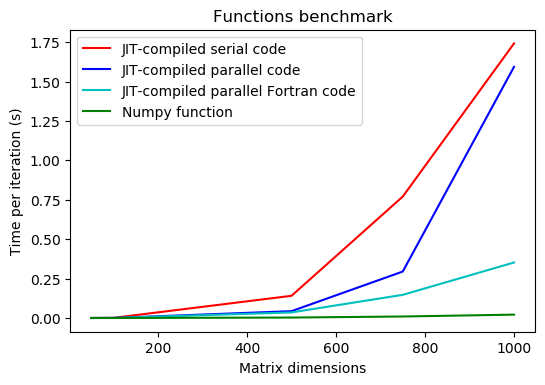

In [80]:
plt.figure(dpi=100)

#Plot the JIT-compiled serial time against the number of dimensions
plt.plot(n, serial_time, 'r', label = "JIT-compiled serial code")

#Plot the JIT-compiled parallel time against the number of dimensions
plt.plot(n, parallel_time, 'b', label = "JIT-compiled parallel code")

#Plot the JIT-compiled parallel Fortran time against the number of dimensions
plt.plot(n, fortran_time, 'c', label = "JIT-compiled parallel Fortran code")

#Plot the Numpy time against the number of dimensions
plt.plot(n, numpy_time, 'g', label = "Numpy function")

#Set the labels, legends and title
plt.title("Functions benchmark")
plt.xlabel("Matrix dimensions")
plt.ylabel("Time per iteration (s)")
plt.legend()

#Plot results
plt.show()

From the graph above it can be observed that the JIT-compiled parallel Fortran function performs better than the JIT-compiled serial and parallel function, but still not better than the Numpy function. However, it is actually a very good approximation of the Numpy function, particularly for smaller dimensions the difference is not significant, whereas for 1000 dimensions, the fortran function just takes 17 times the numpy best benchmark time.

We will now compute the ratios of the serial, parallel and parallel fortran function against the Numpy and original function to check how much our code has improved over all dimensions. 

- Plot the ratios of the JIT-compiled serial, parallel and parallel fortan function best times against the numpy and original functions best time. 

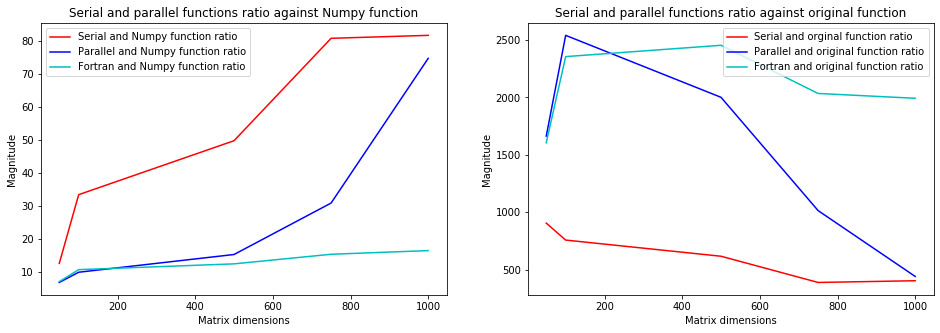

In [81]:
#Compute the ratios
ratio_numpy_serial = serial_time / numpy_time 
ratio_numpy_parallel = parallel_time / numpy_time
ratio_numpy_fortran = fortran_time / numpy_time

ratio_serial_original = function_time / serial_time 
ratio_parallel_original = function_time / parallel_time
ratio_fortran_original = function_time / fortran_time

#Mean of the Parallel Fortran ratios
mean_numpy_fortran = np.mean(ratio_numpy_fortran)
mean_fortran_original = np.mean(ratio_fortran_original)

#Plot the ratios against the number of dimensions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,5))
ax1.plot(n, ratio_numpy_serial, 'r', label = 'Serial and Numpy function ratio')
ax1.plot(n, ratio_numpy_parallel, 'b', label = 'Parallel and Numpy function ratio')
ax1.plot(n, ratio_numpy_fortran, 'c', label = 'Fortran and Numpy function ratio')

ax2.plot(n, ratio_serial_original, 'r', label = 'Serial and orginal function ratio')
ax2.plot(n, ratio_parallel_original, 'b', label = 'Parallel and original function ratio')
ax2.plot(n, ratio_fortran_original, 'c', label = 'Fortran and original function ratio')

#Set the labels, legends and title
ax1.set_title('Serial and parallel functions ratio against Numpy function')
ax1.set_xlabel('Matrix dimensions')
ax1.set_ylabel('Magnitude')
ax1.legend()

ax2.set_title('Serial and parallel functions ratio against original function')
ax2.set_xlabel('Matrix dimensions')
ax2.set_ylabel('Magnitude')
ax2.legend()

#Show results
plt.show()

These graphs show that the parallel fortran function performs better than the serial and parallel function for all dimensions. 

On the first graph we are plotting the ratio of the serial, parallel and fortran best times with the numpy best time. It can be observed that the parallel fortran code on average takes 12 times Numpy's benchmark for all dimensions.

On the second graph we are plotting the serial, parallel and fortran best times with the original function best time. On average, the original function takes 2171 times the parallel fortran function best time. 

Hence it can be concluded that when we order an array in column major order, the performance of our code improves. This is because the array is stored in a contiguous way in memory. Because of this, the machine can directly pre-load those addresses into cache and achieve a higher rate of cache hits. However, when we order an array in any other non-contiguous way then the machine most likely won't be able to find the memory access pattern and it wont directly pull memory addresses into cache. Therefore main memory will have to be accessed more frequently which is slower than the cache. [4]

## Point 4

*We can still try to improve efficiency. A frequent technique to improve efficiency for the matrix-matrix product is through blocking. Consider the command in the inner-most loop mat_c[row_ind, col_ind] += mat_a[row_ind, k] * mat_b[k, col_ind]. Instead of updating a single element mat_c[row_ind, col_ind] we want to update a ℓ×ℓ submatrix. Hence, the inner multiplication becomes itself the product of two ℓ×ℓsubmatrices, and instead of iterating element by element we move forward in terms of ℓ×ℓ blocks. Implement this scheme. For the innermost ℓ×ℓ matrix use a standard serial triple loop. Investigate how benchmark timings depend on the parameter ℓ and how this implementation compares to your previous schemes. For simplicity you may want to choose outer-matrix dimensions that are multiples of ℓ so that you need not deal in your code with the remainder part of the matrix if the dimensions are not divisible by ℓ. Note that while such schemes are used in practical implementations of the matrix-matrix product it is not immediately clear that a Numba implementation here will be advantageous. There is a lot going on in the compiler in between writing Numba loops and actually producing machine code. Real libraries are written in much lower-level languages and can optimize closer to the hardware. Your task is to experiment to see if this blocked approach has advantages within Numba.*

The basic idea behind this code is to partition A and C into 1 × bsize row slivers and to partition B into bsize × bsize blocks. The innermost (j, k) loop pair multiplies a sliver of A by a block of B and accumulates the result into a sliver of C. The i loop iterates through n row slivers of A and C, using the same block in B.

![](image.png)
[1] Image

- Define our blocking function. 

In [82]:
@njit()
def matrix_multiply_blocking(mat_a, mat_b, block_size):
    """Returns the blocked product of mat_a and mat_b."""
    m = mat_a.shape[0]
    n = mat_b.shape[1]

    assert(mat_a.shape[1] == mat_b.shape[0])

    mat_c = np.zeros((m, n), dtype=np.float64)
    
    en = int(block_size * n/block_size) #Amount that fits evenly into blocks 

    for kk in range(0, en, block_size):
        for jj in range(0, en, block_size):
            for i in range(n):
                ai = mat_a[i]
                ci = mat_c[i]
                for j in range(jj, jj + block_size):
                    s = ci[j]
                    for k in range(kk, kk + block_size):
                        s += ai[k] * mat_b[k][j]
                    ci[j] = s
    return mat_c

In [83]:
# Benchmark our function for matrices of different dimensions
n = (50, 100, 500, 750, 1000)   #dimensions we want to benchamark
divisors = np.array([2, 5, 10, 25])       #interger by which we will divide rows and columns of our matrix
blocking_time = np.zeros([len(n), len(divisors)])   #array of the best times that the blocked code takes per divisor
number_blocks = divisors ** 2

#Compute matrices for n dimensions
for i in range(len(n)):
    for j in range(len(number_blocks)):
        n_block = number_blocks[j]        #total number of blocks
        b_size = int(n[i]/divisors[j])    #size of each block
        a = np.random.randn(n[i], n[i])
        b = np.random.randn(n[i], n[i])
        
        #get the benchmark for the blocked function
        print(f"For two matrices of size of {a.shape} and {n_block} blocks of size {b_size}x{b_size}, the blocking code takes:")
        blocking_result_function = %timeit -o matrix_multiply_blocking(a, b, b_size)
        blocking_time[i][j] = blocking_result_function.best
        print()

For two matrices of size of (50, 50) and 4 blocks of size 25x25, the blocking code takes:
123 µs ± 7.58 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

For two matrices of size of (50, 50) and 25 blocks of size 10x10, the blocking code takes:
155 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

For two matrices of size of (50, 50) and 100 blocks of size 5x5, the blocking code takes:
252 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For two matrices of size of (50, 50) and 625 blocks of size 2x2, the blocking code takes:
956 µs ± 20 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For two matrices of size of (100, 100) and 4 blocks of size 50x50, the blocking code takes:
982 µs ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For two matrices of size of (100, 100) and 25 blocks of size 20x20, the blocking code takes:
961 µs ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For two matrices of s

- Plot the best benchmark times against the number of blocks all the dimensions.

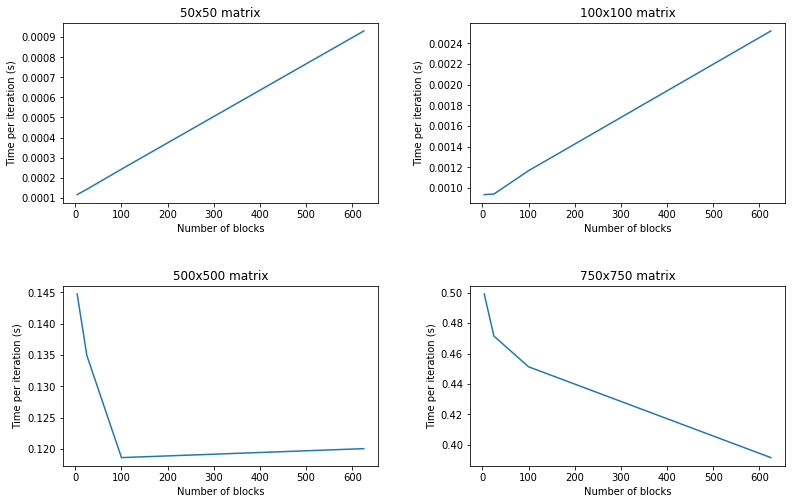

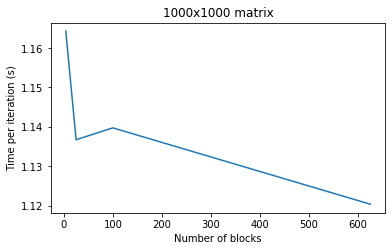

In [84]:
figure, axis = plt.subplots(2, 2, figsize =(12,8))
  
# For 50x50 matrix
axis[0, 0].plot(number_blocks, blocking_time[0])
axis[0, 0].set_title("50x50 matrix")
  
# For 100x100 matrix
axis[0, 1].plot(number_blocks, blocking_time[1])
axis[0, 1].set_title("100x100 matrix")
  
# For 500x500 matrix
axis[1, 0].plot(number_blocks, blocking_time[2])
axis[1, 0].set_title("500x500 matrix")
  
# For 750x750 matrix
axis[1, 1].plot(number_blocks, blocking_time[3])
axis[1, 1].set_title("750x750 matrix")

# For 1000x1000 matrix
plt.figure(figsize =(6,3.5))
plt.plot(number_blocks, blocking_time[4])
plt.title("1000x1000 matrix")

#Set the labels
figure.tight_layout(pad=5)
plt.xlabel("Number of blocks")
plt.ylabel("Time per iteration (s)")

for i in range(2):
    for j in range(2):
        axis[i,j].set_xlabel("Number of blocks")
        axis[i,j].set_ylabel("Time per iteration (s)")

#Plot results
plt.show()

Blocking can make code harder to read, but it can also increase the performance of our code. From the graphs above, it can be observed that as the size of the matrices and number of blocks increase, the time per iteration also linearly increase for matrices of shape 50x50 and 100x100. Hence, the performance decreases for dimensions below a 100, approximately. 

However, for dimensions between 500 and 1000, blocking actually improves the performance of our function. Particularly, for a 100 blocks, the 500x500 matrix display the smallest amount of time per iteration; whereas for the 750x750 and 1000x1000 matrices, the smallest time per iteration is at 625 blocks. 

We can now plot the ratios of all our functions best times against the numpy and original best times to check how much our code has improved and which function performs the best. In order to do this we will average the time of each number of blocks for the set of dimensions and pick the one with the lowest value.

- Select the number of blocks that has the best average benchmark time. 

In [85]:
average_values_per_nblock = []  #list of average benchmark times per block  

for i in range(len(divisors)):
    value = 0
    value = sum(blocking_time[j][i] for j in range(len(n)))
    average_values_per_nblock.append(value)

ideal_number_blocks = divisors[average_values_per_nblock.index(min(average_values_per_nblock))]**2
print(f"The most efficient number of blocks is {ideal_number_blocks}")

The most efficient number of blocks is 625


In [86]:
block_values = np.zeros(5)

for i in range(len(n)):
    block_values[i] = blocking_time[i][3]

- Plot the ratios of all our functions best times against the numpy and original best times

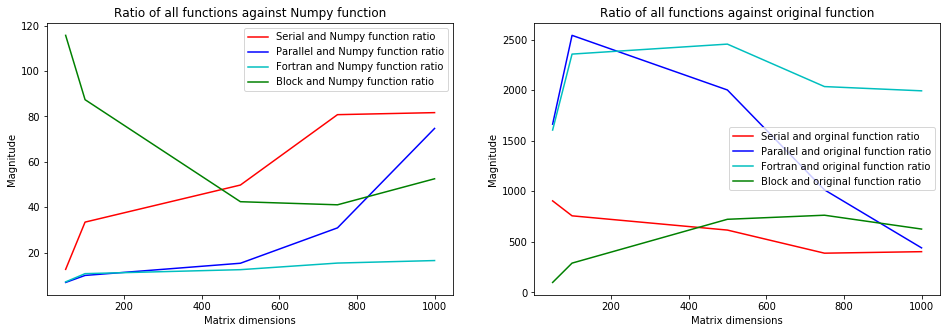

In [87]:
#Compute the ratios
ratio_block5_numpy = block_values / numpy_time
ratio_block5_original = function_time / block_values

#Plot the ratios against the number of dimensions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(16,5))
ax1.plot(n, ratio_numpy_serial, 'r', label = 'Serial and Numpy function ratio')
ax1.plot(n, ratio_numpy_parallel, 'b', label = 'Parallel and Numpy function ratio')
ax1.plot(n, ratio_numpy_fortran, 'c', label = 'Fortran and Numpy function ratio')
ax1.plot(n, ratio_block5_numpy, 'g', label = 'Block and Numpy function ratio')

ax2.plot(n, ratio_serial_original, 'r', label = 'Serial and orginal function ratio')
ax2.plot(n, ratio_parallel_original, 'b', label = 'Parallel and original function ratio')
ax2.plot(n, ratio_fortran_original, 'c', label = 'Fortran and original function ratio')
ax2.plot(n, ratio_block5_original, 'g', label = 'Block and original function ratio')

#Set the labels, legends and title
ax1.set_title('Ratio of all functions against Numpy function')
ax1.set_xlabel('Matrix dimensions')
ax1.set_ylabel('Magnitude')
ax1.legend()

ax2.set_title('Ratio of all functions against original function')
ax2.set_xlabel('Matrix dimensions')
ax2.set_ylabel('Magnitude')
ax2.legend()

On the first graph we are plotting the ratio of all our functions best times with the numpy best time. It can be observed that the blocked function performs poorly for smaller dimensions, but better than the serial code for 500 dimensions, and better for the parallel code for 1000 dimensions. However, the performance of the Fortran function is still the best from all our functions. 

On the second graph we are plotting the ratio of all our functions best times with the original function best time. Again it can be observed the same tendency as described above. For a 1000 dimensions, the blocked function only improved our original function by a factor of 474, on average, which is not comparable to the improvement obtained with the Fortran function of approximately 2171 times the original function. 

One of the reasons why the blocked approach does not present a significant improval in the performance of our code within Numba might be because the degree of cache interference is highly sensitive to the amount of data accesses and the size of the blocks. This can originate big variations in performance for different matrix sizes. 

### Conclusion

From this report, we have reached the following conclusions:
- The JIT compilled parallel function performed better than the JIT compilled serial function for higher dimensions. 
- The JIT-compiled parallel Fortran function performed the best from all our functions. On average, this function takes 12 times Numpy's benchmark best times. Moreover, the original function takes 2171 times this function benchmark best times. 
- Storing data in the same order as they are stored in the memory can significantly improve the performance of our code. 
- The blocked approach does not present any significant advantage within Numba.
- Numba has a number of features than can remarkably improve the performance of our Python code to levels that have only been achieved in languages such as C and Fortran.

### References

[1] Csapp.cs.cmu.edu. 2021. [online] Available at: <https://csapp.cs.cmu.edu/public/waside/waside-blocking.pdf> [Accessed 17 October 2021].

[2] Suif.stanford.edu. 2021. [online] Available at: <https://suif.stanford.edu/papers/lam-asplos91.pdf> [Accessed 17 October 2021].

[3] Shihchinw.github.io. 2021. Performance Tips of NumPy ndarray. [online] Available at: <https://shihchinw.github.io/2019/03/performance-tips-of-numpy-ndarray.html> [Accessed 17 October 2021].

[4] W. and Zorychta, D., 2021. Why is iterating 2D array row major faster than column major?. [online] Stack Overflow. Available at: <https://stackoverflow.com/questions/33722520/why-is-iterating-2d-array-row-major-faster-than-column-major> [Accessed 18 October 2021].
        

In [61]:
#center the graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")